In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 데이터 로드

In [ ]:
diagnoses_icd=pd.read_csv('../data/hosp/diagnoses_icd.csv')
patients=pd.read_csv('../data/hosp/patients.csv')
admissions=pd.read_csv('../data/hosp/admissions.csv')
chartevents = pd.read_csv('../data/chartevents.csv')
labevents = pd.read_csv('../data/hosp/labevents.csv')

In [ ]:
#입원, 퇴원 날짜 기준으로 입원 기간 length_of_stay
admissions['admittime'] = pd.to_datetime(admissions['admittime'])
admissions['dischtime'] = pd.to_datetime(admissions['dischtime'])
admissions['length_of_stay'] = (admissions['dischtime'] - admissions['admittime']).dt.days

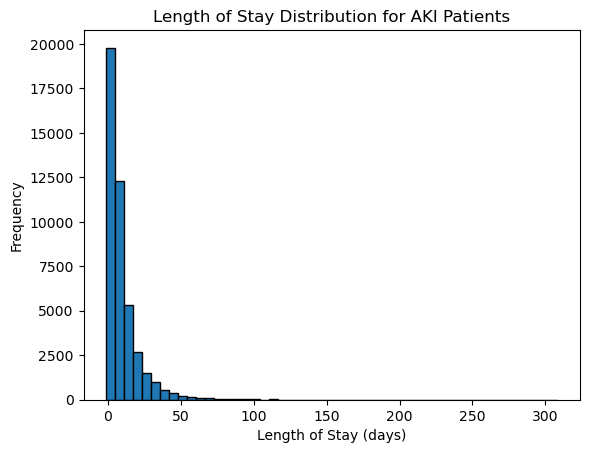

count    44293.000000
mean        10.182602
std         12.873392
min         -1.000000
25%          3.000000
50%          6.000000
75%         13.000000
max        308.000000
Name: length_of_stay, dtype: float64


In [ ]:
AKI_icd_codes = ['5851','5860','5845', '5846', '5847', '5848', 'N170', 'N171', 'N172', 'N178', 'N179'] # 급성 신손상에 해당하는 코드
aki_hadm_ids = diagnoses_icd[diagnoses_icd['icd_code'].isin(AKI_icd_codes)]['hadm_id']
aki_admissions = admissions[admissions['hadm_id'].isin(aki_hadm_ids)]

plt.hist(aki_admissions['length_of_stay'], bins=50, edgecolor='black')
plt.title('Length of Stay Distribution for AKI Patients')
plt.xlabel('Length of Stay (days)')
plt.ylabel('Frequency')
plt.show()

# 분포에 대한 통계 정보 출력
print(aki_admissions['length_of_stay'].describe())

In [30]:
#입원 기간 7일 이상 30일 이하인 환자만 사용, list up
data = admissions[(admissions['length_of_stay'] >= 7) & (admissions['length_of_stay'] <= 14)]
data = data[['subject_id', 'hadm_id', 'length_of_stay']]

,subject_id,hadm_id,length_of_stay
16,10000690,23280645,7
17,10000690,25860671,9
25,10000883,25221576,7
33,10000935,29541074,7
38,10000980,25242409,7
...,...,...,...
545985,19999442,25345411,8
546010,19999784,25715748,8
546012,19999784,26194817,13
546023,19999828,25744818,10


In [ ]:
#chartevents에서 사용할 입원 아이디의 정보만 
chartevents = chartevents[chartevents['hadm_id'].isin(data['hadm_id'])]

In [3]:
chartevents=chartevents.drop(['stay_id', 'caregiver_id','storetime'], axis=1)

In [9]:
#day 기준 시간 정보만 남기기
chartevents['chartdate'] = pd.to_datetime(chartevents['charttime']).dt.date
chartevents.head()

,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,chartdate
0,10000032,29079034,39553978,18704.0,2180-07-23 12:36:00,2180-07-23 14:45:00,226512,39.4,39.4,kg,0.0,2180-07-23
1,10000032,29079034,39553978,18704.0,2180-07-23 12:36:00,2180-07-23 14:45:00,226707,60,60.0,Inch,0.0,2180-07-23
2,10000032,29079034,39553978,18704.0,2180-07-23 12:36:00,2180-07-23 14:45:00,226730,152,152.0,cm,0.0,2180-07-23
3,10000032,29079034,39553978,18704.0,2180-07-23 14:00:00,2180-07-23 14:18:00,220048,SR (Sinus Rhythm),NaN,NaN,0.0,2180-07-23
4,10000032,29079034,39553978,18704.0,2180-07-23 14:00:00,2180-07-23 14:18:00,224642,Oral,NaN,NaN,0.0,2180-07-23


## vital

In [47]:
#사용할 itemid (바이탈, 피검사 결과 등)만 필터링
important_itemids = [
    220050, 220051, 220052, 220045, 224674, 220277,220179, 220180, 220181  # 혈압, 심박수, 체온, 산소 포화도
]
vital_chartevents = chartevents[chartevents['itemid'].isin(important_itemids)]

In [ ]:
filtered_data = vital_chartevents[vital_chartevents['itemid'].isin([220050, 220179])]  #SBP
filtered_data.loc[(filtered_data['valuenum'] < 50) | (filtered_data['valuenum'] > 250), 'valuenum'] = np.nan# SBP 이상치 제거

# SBP_min, SBP_max, SBP_mean을 계산하고, 차트 날짜별로 하나의 행으로 그룹화
agg_data = (
    filtered_data.groupby(['hadm_id', 'chartdate'])
    .agg(
        SBP_min=('valuenum', 'min'),
        SBP_max=('valuenum', 'max'),
        SBP_mean=('valuenum', 'mean')
    )
    .reset_index()
)

# 최종 결과 데이터프레임에 원래 데이터와 결합
final_data = pd.merge(filtered_data, agg_data, on=['hadm_id', 'chartdate'])

# 차트 날짜별로 하나의 행만 남기기
final_data = final_data.drop_duplicates(subset=['hadm_id', 'chartdate'])
final_data = final_data.sort_values(by=['hadm_id', 'chartdate']).reset_index(drop=True)
# DBP 관련 itemid
dbp_itemids = [220051, 220180]

# DBP 데이터 필터링
dbp_data = vital_chartevents[vital_chartevents['itemid'].isin(dbp_itemids)]
dbp_data.loc[(dbp_data['valuenum'] < 30) | (dbp_data['valuenum'] > 200), 'valuenum'] = np.nan

# chartdate에 대해 최소, 최대, 평균 계산
dbp_aggregated = dbp_data.groupby(['hadm_id', 'chartdate']).agg(
    DBP_min=('valuenum', 'min'),
    DBP_max=('valuenum', 'max'),
    DBP_mean=('valuenum', 'mean')
).reset_index()

# final_data에 DBP 관련 컬럼 추가
final_data = final_data.merge(dbp_aggregated, on=['hadm_id', 'chartdate'], how='left')

# MAP 관련 itemid
map_itemids = [220052, 220181]

# MAP 데이터 필터링
map_data = vital_chartevents[vital_chartevents['itemid'].isin(map_itemids)]
map_data.loc[(map_data['valuenum'] < 20) | (map_data['valuenum'] > 200), 'valuenum'] = np.nan

# chartdate에 대해 최소, 최대, 평균 계산
map_aggregated = map_data.groupby(['hadm_id', 'chartdate']).agg(
    MAP_min=('valuenum', 'min'),
    MAP_max=('valuenum', 'max'),
    MAP_mean=('valuenum', 'mean')
).reset_index()

# final_data에 MAP 관련 컬럼 추가
final_data = final_data.merge(map_aggregated, on=['hadm_id', 'chartdate'], how='left')
# Vital signs 관련 itemid
hr_itemid = 220045
bt_itemid = 224674
spO2_itemid = 220277

# Heart rate 데이터 필터링
hr_data = vital_chartevents[vital_chartevents['itemid'] == hr_itemid]
hr_data.loc[(hr_data['valuenum'] < 20) | (hr_data['valuenum'] > 250), 'valuenum'] = np.nan

# Body temperature 데이터 필터링
bt_data = vital_chartevents[vital_chartevents['itemid'] == bt_itemid]
# set(bt_data['valuenum']) # 0,1,2만 있어서 그냥 이상치 제거 안함
# Oxygen saturation 데이터 필터링
spO2_data = vital_chartevents[vital_chartevents['itemid'] == spO2_itemid]
spO2_data.loc[(spO2_data['valuenum'] <= 30) | (spO2_data['valuenum'] > 100), 'valuenum'] = np.nan

# 각각 chartdate에 대해 최소, 최대, 평균 계산
hr_aggregated = hr_data.groupby(['hadm_id', 'chartdate']).agg(
    HR_min=('valuenum', 'min'),
    HR_max=('valuenum', 'max'),
    HR_mean=('valuenum', 'mean')
).reset_index()

bt_aggregated = bt_data.groupby(['hadm_id', 'chartdate']).agg(
    BT_mode=('valuenum', lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)  # 최빈값 추가
).reset_index()

spO2_aggregated = spO2_data.groupby(['hadm_id', 'chartdate']).agg(
    SpO2_min=('valuenum', 'min'),
    SpO2_max=('valuenum', 'max'),
    SpO2_mean=('valuenum', 'mean')
).reset_index()

# final_data에 각각의 컬럼 추가
final_data = final_data.merge(hr_aggregated, on=['hadm_id', 'chartdate'], how='left')
final_data = final_data.merge(bt_aggregated, on=['hadm_id', 'chartdate'], how='left')
final_data = final_data.merge(spO2_aggregated, on=['hadm_id', 'chartdate'], how='left')

final_data=final_data.drop(['charttime','value', 'valuenum', 'valueuom'], axis=1)
final_data=final_data.drop(['BT_mode', 'itemid'], axis=1)



In [66]:
final_data=final_data.drop(['BT_min','BT_max', 'BT_mean', 'itemid'], axis=1)
final_data

,subject_id,hadm_id,warning,chartdate,SBP_min,SBP_max,SBP_mean,DBP_min,DBP_max,DBP_mean,MAP_min,MAP_max,MAP_mean,HR_min,HR_max,HR_mean,SpO2_min,SpO2_max,SpO2_mean
0,16788749,20000808,0.0,2180-01-12,181.0,181.0,181.000000,102.0,102.0,102.000000,122.0,122.0,122.000000,84.0,85.0,84.666667,98.0,99.0,98.333333
1,16788749,20000808,0.0,2180-01-13,111.0,173.0,139.181818,77.0,109.0,90.818182,86.0,124.0,102.181818,77.0,98.0,82.666667,96.0,100.0,97.416667
2,16788749,20000808,0.0,2180-01-17,117.0,182.0,153.000000,75.0,94.0,85.250000,92.0,127.0,112.750000,57.0,90.0,69.200000,99.0,100.0,99.600000
3,16788749,20000808,0.0,2180-01-18,101.0,150.0,122.689655,54.0,106.0,79.551724,66.0,143.0,93.724138,68.0,106.0,84.750000,92.0,99.0,97.000000
4,16788749,20000808,0.0,2180-01-19,111.0,155.0,131.550000,67.0,98.0,81.000000,80.0,111.0,92.950000,71.0,103.0,86.100000,92.0,99.0,96.350000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118775,10053207,29999444,0.0,2199-12-15,111.0,150.0,134.291667,63.0,130.0,78.250000,75.0,134.0,91.041667,115.0,134.0,123.583333,92.0,96.0,94.666667
118776,10053207,29999444,0.0,2199-12-16,116.0,159.0,136.750000,66.0,103.0,80.458333,76.0,116.0,93.291667,109.0,134.0,120.000000,94.0,97.0,95.250000
118777,10053207,29999444,0.0,2199-12-17,101.0,155.0,133.869565,54.0,89.0,76.217391,62.0,102.0,89.521739,109.0,133.0,122.083333,94.0,97.0,95.541667
118778,13478841,29999498,0.0,2188-05-13,137.0,152.0,144.250000,62.0,117.0,70.416667,82.0,126.0,88.833333,87.0,101.0,94.142857,92.0,97.0,95.285714


## chartevents

In [10]:
# 'hadm_id'를 정수형으로, 'chartdate'를 날짜 형식으로 변환
final_data['hadm_id'] = final_data['hadm_id'].astype(int)
chartevents['hadm_id'] = chartevents['hadm_id'].astype(int)

final_data['chartdate'] = pd.to_datetime(final_data['chartdate'])
chartevents['chartdate'] = pd.to_datetime(chartevents['chartdate'])


In [13]:
#Creatinine 데이터 필터링 (itemid가 220615)
creatinine_itemid = 220615
creatinine_data = chartevents[chartevents['itemid'] == creatinine_itemid]
creatinine_data.loc[(creatinine_data['valuenum'] <= 0) | (creatinine_data['valuenum'] > 50), 'valuenum'] = np.nan
creatinine_data = creatinine_data[(creatinine_data['valuenum']>=0)&(creatinine_data['valuenum']<50)]

# chartdate에 대해 평균 계산
creatinine_aggregated = creatinine_data.groupby(['hadm_id', 'chartdate']).agg(
    Creatinine_mean=('valuenum', 'mean')
).reset_index()

# final_data에 Creatinine_mean 컬럼 추가
final_data = final_data.merge(creatinine_aggregated, on=['hadm_id', 'chartdate'], how='left')

# 최종 결과 출력
final_data

,subject_id,hadm_id,warning,chartdate,SBP_min,SBP_max,SBP_mean,DBP_min,DBP_max,DBP_mean,MAP_min,MAP_max,MAP_mean,HR_min,HR_max,HR_mean,SpO2_min,SpO2_max,SpO2_mean,Creatinine_mean
0,16788749,20000808,0.0,2180-01-12,181.0,181.0,181.000000,102.0,102.0,102.000000,122.0,122.0,122.000000,84.0,85.0,84.666667,98.0,99.0,98.333333,NaN
1,16788749,20000808,0.0,2180-01-13,111.0,173.0,139.181818,77.0,109.0,90.818182,86.0,124.0,102.181818,77.0,98.0,82.666667,96.0,100.0,97.416667,0.60
2,16788749,20000808,0.0,2180-01-17,117.0,182.0,153.000000,75.0,94.0,85.250000,92.0,127.0,112.750000,57.0,90.0,69.200000,99.0,100.0,99.600000,NaN
3,16788749,20000808,0.0,2180-01-18,101.0,150.0,122.689655,54.0,106.0,79.551724,66.0,143.0,93.724138,68.0,106.0,84.750000,92.0,99.0,97.000000,0.70
4,16788749,20000808,0.0,2180-01-19,111.0,155.0,131.550000,67.0,98.0,81.000000,80.0,111.0,92.950000,71.0,103.0,86.100000,92.0,99.0,96.350000,0.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221747,10053207,29999444,0.0,2199-12-15,111.0,150.0,134.291667,63.0,130.0,78.250000,75.0,134.0,91.041667,115.0,134.0,123.583333,92.0,96.0,94.666667,2.40
221748,10053207,29999444,0.0,2199-12-16,116.0,159.0,136.750000,66.0,103.0,80.458333,76.0,116.0,93.291667,109.0,134.0,120.000000,94.0,97.0,95.250000,2.60
221749,10053207,29999444,0.0,2199-12-17,101.0,155.0,133.869565,54.0,89.0,76.217391,62.0,102.0,89.521739,109.0,133.0,122.083333,94.0,97.0,95.541667,1.90
221750,13478841,29999498,0.0,2188-05-13,137.0,152.0,144.250000,62.0,117.0,70.416667,82.0,126.0,88.833333,87.0,101.0,94.142857,92.0,97.0,95.285714,1.20


In [14]:
laboratory_chartevents=chartevents
del chartevents

In [15]:
WBC_itemid = 220546
WBC_data = laboratory_chartevents[laboratory_chartevents['itemid'] == WBC_itemid]
WBC_data.loc[(WBC_data['valuenum'] <= 0) | (WBC_data['valuenum'] > 500), 'valuenum'] = np.nan
# chartdate에 대해 평균 계산
WBC_aggregated = WBC_data.groupby(['hadm_id', 'chartdate']).agg(
    WBC_mean=('valuenum', 'mean')
).reset_index()

final_data = final_data.merge(WBC_aggregated, on=['hadm_id', 'chartdate'], how='left')


Hemoglobin_itemid = 220228 ; Platelet_itemid = 227457;Albumin_itemid = 227456
data = laboratory_chartevents[laboratory_chartevents['itemid'] == Hemoglobin_itemid]
data.loc[(data['valuenum'] <= 0) | (data['valuenum'] > 50), 'valuenum'] = np.nan

Hemoglobin_itemid = 220228 ; Platelet_itemid = 227457;Albumin_itemid = 227456
data = laboratory_chartevents[laboratory_chartevents['itemid'] == Hemoglobin_itemid]
data.loc[(data['valuenum'] <= 0) | (data['valuenum'] > 25), 'valuenum'] = np.nan
# chartdate에 대해 평균 계산
data_aggregated = data.groupby(['hadm_id', 'chartdate']).agg(
    Hemoglobin_mean=('valuenum', 'mean')
).reset_index()
final_data = final_data.merge(data_aggregated, on=['hadm_id', 'chartdate'], how='left')


data = laboratory_chartevents[laboratory_chartevents['itemid'] == Platelet_itemid]
data.loc[(data['valuenum'] <= 0) | (data['valuenum'] > 1500), 'valuenum'] = np.nan
# chartdate에 대해 평균 계산
data_aggregated = data.groupby(['hadm_id', 'chartdate']).agg(
    Platelet_mean=('valuenum', 'mean')
).reset_index()
final_data = final_data.merge(data_aggregated, on=['hadm_id', 'chartdate'], how='left')


data = laboratory_chartevents[laboratory_chartevents['itemid'] == Albumin_itemid]
data.loc[(data['valuenum'] <= 0) | (data['valuenum'] > 8), 'valuenum'] = np.nan
# chartdate에 대해 평균 계산
data_aggregated = data.groupby(['hadm_id', 'chartdate']).agg(
     Albumin_mean=('valuenum', 'mean')
).reset_index()
final_data = final_data.merge(data_aggregated, on=['hadm_id', 'chartdate'], how='left')



Sodium = [220645, 226534] # mEq/L	
data = laboratory_chartevents[laboratory_chartevents['itemid'].isin(Sodium)]
data.loc[(data['valuenum'] <= 100) | (data['valuenum'] > 200), 'valuenum'] = np.nan
# chartdate에 대해 평균 계산
data_aggregated = data.groupby(['hadm_id', 'chartdate']).agg(
     Sodium_mean=('valuenum', 'mean')
).reset_index()
final_data = final_data.merge(data_aggregated, on=['hadm_id', 'chartdate'], how='left')


Potassium = [227442] #  mEq/L
data = laboratory_chartevents[laboratory_chartevents['itemid'].isin(Potassium)]
data.loc[(data['valuenum'] <= 2.5) | (data['valuenum'] > 10), 'valuenum'] = np.nan
# chartdate에 대해 평균 계산
data_aggregated = data.groupby(['hadm_id', 'chartdate']).agg(
     Potassium_mean=('valuenum', 'mean')
).reset_index()
final_data = final_data.merge(data_aggregated, on=['hadm_id', 'chartdate'], how='left')


Chloride = [220602, 226536] # mEq/L	
data = laboratory_chartevents[laboratory_chartevents['itemid'].isin(Chloride)]
data.loc[(data['valuenum'] <= 80) | (data['valuenum'] > 130), 'valuenum'] = np.nan
# chartdate에 대해 평균 계산
data_aggregated = data.groupby(['hadm_id', 'chartdate']).agg(
    Chloride_mean=('valuenum', 'mean')
).reset_index()
final_data = final_data.merge(data_aggregated, on=['hadm_id', 'chartdate'], how='left')


AST = [220587] # IU/L	
data = laboratory_chartevents[laboratory_chartevents['itemid'].isin(AST)]
data.loc[(data['valuenum'] <= 0) | (data['valuenum'] > 5000), 'valuenum'] = np.nan
# chartdate에 대해 평균 계산
data_aggregated = data.groupby(['hadm_id', 'chartdate']).agg(
    AST_mean=('valuenum', 'mean')
).reset_index()
final_data = final_data.merge(data_aggregated, on=['hadm_id', 'chartdate'], how='left')


ALT = [220644] #  IU/L
data = laboratory_chartevents[laboratory_chartevents['itemid'].isin(ALT)]
data.loc[(data['valuenum'] <= 0) | (data['valuenum'] > 5000), 'valuenum'] = np.nan
# chartdate에 대해 평균 계산
data_aggregated = data.groupby(['hadm_id', 'chartdate']).agg(
    ALT_mean=('valuenum', 'mean')
).reset_index()
final_data = final_data.merge(data_aggregated, on=['hadm_id', 'chartdate'], how='left')


Bilirubin = [225651, 225690]
data = laboratory_chartevents[laboratory_chartevents['itemid'].isin(Bilirubin)]
data.loc[(data['valuenum'] <= 0) | (data['valuenum'] > 50), 'valuenum'] = np.nan
# chartdate에 대해 평균 계산
data_aggregated = data.groupby(['hadm_id', 'chartdate']).agg(
    Bilirubin_mean=('valuenum', 'mean')
).reset_index()
final_data = final_data.merge(data_aggregated, on=['hadm_id', 'chartdate'], how='left')

Glucose = [220621, 226537]
data = laboratory_chartevents[laboratory_chartevents['itemid'].isin(Glucose)]
data.loc[(data['valuenum'] <= 0) | (data['valuenum'] > 1000), 'valuenum'] = np.nan
# chartdate에 대해 평균 계산
data_aggregated = data.groupby(['hadm_id', 'chartdate']).agg(
    Glucose_mean=('valuenum', 'mean')
).reset_index()
final_data = final_data.merge(data_aggregated, on=['hadm_id', 'chartdate'], how='left')

CK = [225632, 225634]
data = laboratory_chartevents[laboratory_chartevents['itemid'].isin(CK)]
data.loc[(data['valuenum'] <= 0) | (data['valuenum'] >  50000), 'valuenum'] = np.nan
# chartdate에 대해 평균 계산
data_aggregated = data.groupby(['hadm_id', 'chartdate']).agg(
    CK_mean=('valuenum', 'mean')
).reset_index()
final_data = final_data.merge(data_aggregated, on=['hadm_id', 'chartdate'], how='left')


Lipase = [225672]
data = laboratory_chartevents[laboratory_chartevents['itemid'].isin(Lipase)]
data.loc[(data['valuenum'] <= 0) | (data['valuenum'] >  10000), 'valuenum'] = np.nan
# chartdate에 대해 평균 계산
data_aggregated = data.groupby(['hadm_id', 'chartdate']).agg(
    Lipase_mean=('valuenum', 'mean')
).reset_index()
final_data = final_data.merge(data_aggregated, on=['hadm_id', 'chartdate'], how='left')
final_data

,subject_id,hadm_id,warning,chartdate,SBP_min,SBP_max,SBP_mean,DBP_min,DBP_max,DBP_mean,MAP_min,MAP_max,MAP_mean,HR_min,HR_max,HR_mean,SpO2_min,SpO2_max,SpO2_mean,Creatinine_mean,WBC_mean,Hemoglobin_mean,Platelet_mean,Albumin_mean_x,Albumin_mean_y,Potassium_mean,Chloride_mean,AST_mean,ALT_mean,Bilirubin_mean,Glucose_mean,CK_mean,Lipase_mean
0,16788749,20000808,0.0,2180-01-12,181.0,181.0,181.000000,102.0,102.0,102.000000,122.0,122.0,122.000000,84.0,85.0,84.666667,98.0,99.0,98.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,16788749,20000808,0.0,2180-01-13,111.0,173.0,139.181818,77.0,109.0,90.818182,86.0,124.0,102.181818,77.0,98.0,82.666667,96.0,100.0,97.416667,0.60,5.4,13.2,312.0,NaN,NaN,4.8,105.0,NaN,NaN,NaN,156.0,NaN,NaN
2,16788749,20000808,0.0,2180-01-17,117.0,182.0,153.000000,75.0,94.0,85.250000,92.0,127.0,112.750000,57.0,90.0,69.200000,99.0,100.0,99.600000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,16788749,20000808,0.0,2180-01-18,101.0,150.0,122.689655,54.0,106.0,79.551724,66.0,143.0,93.724138,68.0,106.0,84.750000,92.0,99.0,97.000000,0.70,15.2,10.9,326.0,NaN,NaN,3.9,103.0,NaN,NaN,NaN,109.0,NaN,NaN
4,16788749,20000808,0.0,2180-01-19,111.0,155.0,131.550000,67.0,98.0,81.000000,80.0,111.0,92.950000,71.0,103.0,86.100000,92.0,99.0,96.350000,0.70,14.1,12.1,254.0,NaN,NaN,4.1,100.0,NaN,NaN,NaN,126.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221747,10053207,29999444,0.0,2199-12-15,111.0,150.0,134.291667,63.0,130.0,78.250000,75.0,134.0,91.041667,115.0,134.0,123.583333,92.0,96.0,94.666667,2.40,7.9,7.9,318.0,NaN,NaN,4.1,112.0,63.0,48.0,0.1,98.0,NaN,NaN
221748,10053207,29999444,0.0,2199-12-16,116.0,159.0,136.750000,66.0,103.0,80.458333,76.0,116.0,93.291667,109.0,134.0,120.000000,94.0,97.0,95.250000,2.60,8.0,8.6,351.0,NaN,NaN,4.2,110.0,76.0,55.0,0.2,90.0,NaN,NaN
221749,10053207,29999444,0.0,2199-12-17,101.0,155.0,133.869565,54.0,89.0,76.217391,62.0,102.0,89.521739,109.0,133.0,122.083333,94.0,97.0,95.541667,1.90,7.9,8.0,390.0,NaN,NaN,3.7,110.0,NaN,NaN,NaN,92.0,NaN,NaN
221750,13478841,29999498,0.0,2188-05-13,137.0,152.0,144.250000,62.0,117.0,70.416667,82.0,126.0,88.833333,87.0,101.0,94.142857,92.0,97.0,95.285714,1.20,NaN,NaN,NaN,NaN,NaN,4.6,100.0,NaN,NaN,NaN,76.0,NaN,NaN


In [16]:
Sodium = [220645, 226534] # mEq/L	
data = laboratory_chartevents[laboratory_chartevents['itemid'].isin(Sodium)]
data.loc[(data['valuenum'] <= 100) | (data['valuenum'] > 200), 'valuenum'] = np.nan
# chartdate에 대해 평균 계산
data_aggregated = data.groupby(['hadm_id', 'chartdate']).agg(
     Sodium_mean=('valuenum', 'mean')
).reset_index()
final_data = final_data.merge(data_aggregated, on=['hadm_id', 'chartdate'], how='left')
final_data

,subject_id,hadm_id,warning,chartdate,SBP_min,SBP_max,SBP_mean,DBP_min,DBP_max,DBP_mean,MAP_min,MAP_max,MAP_mean,HR_min,HR_max,HR_mean,SpO2_min,SpO2_max,SpO2_mean,Creatinine_mean,WBC_mean,Hemoglobin_mean,Platelet_mean,Albumin_mean_x,Albumin_mean_y,Potassium_mean,Chloride_mean,AST_mean,ALT_mean,Bilirubin_mean,Glucose_mean,CK_mean,Lipase_mean,Sodium_mean
0,16788749,20000808,0.0,2180-01-12,181.0,181.0,181.000000,102.0,102.0,102.000000,122.0,122.0,122.000000,84.0,85.0,84.666667,98.0,99.0,98.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,16788749,20000808,0.0,2180-01-13,111.0,173.0,139.181818,77.0,109.0,90.818182,86.0,124.0,102.181818,77.0,98.0,82.666667,96.0,100.0,97.416667,0.60,5.4,13.2,312.0,NaN,NaN,4.8,105.0,NaN,NaN,NaN,156.0,NaN,NaN,138.0
2,16788749,20000808,0.0,2180-01-17,117.0,182.0,153.000000,75.0,94.0,85.250000,92.0,127.0,112.750000,57.0,90.0,69.200000,99.0,100.0,99.600000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,16788749,20000808,0.0,2180-01-18,101.0,150.0,122.689655,54.0,106.0,79.551724,66.0,143.0,93.724138,68.0,106.0,84.750000,92.0,99.0,97.000000,0.70,15.2,10.9,326.0,NaN,NaN,3.9,103.0,NaN,NaN,NaN,109.0,NaN,NaN,138.0
4,16788749,20000808,0.0,2180-01-19,111.0,155.0,131.550000,67.0,98.0,81.000000,80.0,111.0,92.950000,71.0,103.0,86.100000,92.0,99.0,96.350000,0.70,14.1,12.1,254.0,NaN,NaN,4.1,100.0,NaN,NaN,NaN,126.0,NaN,NaN,135.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221747,10053207,29999444,0.0,2199-12-15,111.0,150.0,134.291667,63.0,130.0,78.250000,75.0,134.0,91.041667,115.0,134.0,123.583333,92.0,96.0,94.666667,2.40,7.9,7.9,318.0,NaN,NaN,4.1,112.0,63.0,48.0,0.1,98.0,NaN,NaN,141.5
221748,10053207,29999444,0.0,2199-12-16,116.0,159.0,136.750000,66.0,103.0,80.458333,76.0,116.0,93.291667,109.0,134.0,120.000000,94.0,97.0,95.250000,2.60,8.0,8.6,351.0,NaN,NaN,4.2,110.0,76.0,55.0,0.2,90.0,NaN,NaN,140.0
221749,10053207,29999444,0.0,2199-12-17,101.0,155.0,133.869565,54.0,89.0,76.217391,62.0,102.0,89.521739,109.0,133.0,122.083333,94.0,97.0,95.541667,1.90,7.9,8.0,390.0,NaN,NaN,3.7,110.0,NaN,NaN,NaN,92.0,NaN,NaN,143.0
221750,13478841,29999498,0.0,2188-05-13,137.0,152.0,144.250000,62.0,117.0,70.416667,82.0,126.0,88.833333,87.0,101.0,94.142857,92.0,97.0,95.285714,1.20,NaN,NaN,NaN,NaN,NaN,4.6,100.0,NaN,NaN,NaN,76.0,NaN,NaN,137.0


In [17]:
final_data=final_data.drop(['Albumin_mean_x','Albumin_mean_y'], axis=1)

In [19]:
patients=pd.read_csv('/home/nhkim/med_datacon/juhye/patients1.csv')

In [22]:
patients.columns

Index(['subject_id', 'gender', 'anchor_age', 'anchor_year',
       'anchor_year_group', 'dod', 'medicine', 'icd_code', 'race', 'weight',
       'height', 'diagnose'],
      dtype='object')

In [20]:
df_merged = pd.merge(final_data, patients[['subject_id', 'gender', 'anchor_age','race', 'medicine', 'weight', 'height', 'diagnose']], 
                     on='subject_id', how='left')
df_merged

,subject_id,hadm_id,warning,chartdate,SBP_min,SBP_max,SBP_mean,DBP_min,DBP_max,DBP_mean,MAP_min,MAP_max,MAP_mean,HR_min,HR_max,HR_mean,SpO2_min,SpO2_max,SpO2_mean,Creatinine_mean,WBC_mean,Hemoglobin_mean,Platelet_mean,Potassium_mean,Chloride_mean,AST_mean,ALT_mean,Bilirubin_mean,Glucose_mean,CK_mean,Lipase_mean,Sodium_mean,gender,anchor_age,race,medicine,weight,height,diagnose
0,16788749,20000808,0.0,2180-01-12,181.0,181.0,181.000000,102.0,102.0,102.000000,122.0,122.0,122.000000,84.0,85.0,84.666667,98.0,99.0,98.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,54,WHITE,1,49.0,NaN,0
1,16788749,20000808,0.0,2180-01-13,111.0,173.0,139.181818,77.0,109.0,90.818182,86.0,124.0,102.181818,77.0,98.0,82.666667,96.0,100.0,97.416667,0.60,5.4,13.2,312.0,4.8,105.0,NaN,NaN,NaN,156.0,NaN,NaN,138.0,1,54,WHITE,1,49.0,NaN,0
2,16788749,20000808,0.0,2180-01-17,117.0,182.0,153.000000,75.0,94.0,85.250000,92.0,127.0,112.750000,57.0,90.0,69.200000,99.0,100.0,99.600000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,54,WHITE,1,49.0,NaN,0
3,16788749,20000808,0.0,2180-01-18,101.0,150.0,122.689655,54.0,106.0,79.551724,66.0,143.0,93.724138,68.0,106.0,84.750000,92.0,99.0,97.000000,0.70,15.2,10.9,326.0,3.9,103.0,NaN,NaN,NaN,109.0,NaN,NaN,138.0,1,54,WHITE,1,49.0,NaN,0
4,16788749,20000808,0.0,2180-01-19,111.0,155.0,131.550000,67.0,98.0,81.000000,80.0,111.0,92.950000,71.0,103.0,86.100000,92.0,99.0,96.350000,0.70,14.1,12.1,254.0,4.1,100.0,NaN,NaN,NaN,126.0,NaN,NaN,135.0,1,54,WHITE,1,49.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221747,10053207,29999444,0.0,2199-12-15,111.0,150.0,134.291667,63.0,130.0,78.250000,75.0,134.0,91.041667,115.0,134.0,123.583333,92.0,96.0,94.666667,2.40,7.9,7.9,318.0,4.1,112.0,63.0,48.0,0.1,98.0,NaN,NaN,141.5,1,55,WHITE,1,93.8,NaN,3
221748,10053207,29999444,0.0,2199-12-16,116.0,159.0,136.750000,66.0,103.0,80.458333,76.0,116.0,93.291667,109.0,134.0,120.000000,94.0,97.0,95.250000,2.60,8.0,8.6,351.0,4.2,110.0,76.0,55.0,0.2,90.0,NaN,NaN,140.0,1,55,WHITE,1,93.8,NaN,3
221749,10053207,29999444,0.0,2199-12-17,101.0,155.0,133.869565,54.0,89.0,76.217391,62.0,102.0,89.521739,109.0,133.0,122.083333,94.0,97.0,95.541667,1.90,7.9,8.0,390.0,3.7,110.0,NaN,NaN,NaN,92.0,NaN,NaN,143.0,1,55,WHITE,1,93.8,NaN,3
221750,13478841,29999498,0.0,2188-05-13,137.0,152.0,144.250000,62.0,117.0,70.416667,82.0,126.0,88.833333,87.0,101.0,94.142857,92.0,97.0,95.285714,1.20,NaN,NaN,NaN,4.6,100.0,NaN,NaN,NaN,76.0,NaN,NaN,137.0,0,77,WHITE,1,80.1,162.56,0


In [23]:
df_merged = df_merged.dropna(subset=['Creatinine_mean'])
len(df_merged)

204833

In [24]:
threshold = 0.7  # 70%
nan_columns = df_merged.columns[df_merged.isnull().mean() >= threshold]
nan_columns # ['Albumin_mean_x', 'AST_mean', 'ALT_mean', 'Bilirubin_mean', 'CK_mean','Lipase_mean']
df_merged.drop(columns=nan_columns, axis = 1, inplace = True)

/tmp/ipykernel_15561/3314400763.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged.drop(columns=nan_columns, axis = 1, inplace = True)


In [25]:
df_merged=df_merged.drop('warning', axis=1)

In [26]:
df_merged

,subject_id,hadm_id,chartdate,SBP_min,SBP_max,SBP_mean,DBP_min,DBP_max,DBP_mean,MAP_min,MAP_max,MAP_mean,HR_min,HR_max,HR_mean,SpO2_min,SpO2_max,SpO2_mean,Creatinine_mean,WBC_mean,Hemoglobin_mean,Platelet_mean,Potassium_mean,Chloride_mean,AST_mean,ALT_mean,Bilirubin_mean,Glucose_mean,Sodium_mean,gender,anchor_age,race,medicine,weight,height,diagnose
1,16788749,20000808,2180-01-13,111.0,173.0,139.181818,77.0,109.0,90.818182,86.0,124.0,102.181818,77.0,98.0,82.666667,96.0,100.0,97.416667,0.60,5.4,13.2,312.0,4.80,105.0,NaN,NaN,NaN,156.0,138.0,1,54,WHITE,1,49.0,NaN,0
3,16788749,20000808,2180-01-18,101.0,150.0,122.689655,54.0,106.0,79.551724,66.0,143.0,93.724138,68.0,106.0,84.750000,92.0,99.0,97.000000,0.70,15.2,10.9,326.0,3.90,103.0,NaN,NaN,NaN,109.0,138.0,1,54,WHITE,1,49.0,NaN,0
4,16788749,20000808,2180-01-19,111.0,155.0,131.550000,67.0,98.0,81.000000,80.0,111.0,92.950000,71.0,103.0,86.100000,92.0,99.0,96.350000,0.70,14.1,12.1,254.0,4.10,100.0,NaN,NaN,NaN,126.0,135.0,1,54,WHITE,1,49.0,NaN,0
5,14577567,20001361,2143-05-04,102.0,125.0,116.333333,75.0,86.0,79.833333,83.0,95.0,87.666667,73.0,82.0,75.100000,85.0,100.0,94.125000,2.50,19.3,11.9,221.5,5.75,107.5,4323.0,3558.0,0.5,142.5,137.0,0,30,WHITE,1,92.0,182.88,1
6,14577567,20001361,2143-05-07,123.0,159.0,140.166667,66.0,82.0,73.833333,83.0,104.0,91.166667,72.0,89.0,76.956522,97.0,99.0,97.826087,4.05,14.0,11.7,265.0,3.50,112.0,1277.0,3089.0,0.7,112.0,148.0,0,30,WHITE,1,92.0,182.88,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221747,10053207,29999444,2199-12-15,111.0,150.0,134.291667,63.0,130.0,78.250000,75.0,134.0,91.041667,115.0,134.0,123.583333,92.0,96.0,94.666667,2.40,7.9,7.9,318.0,4.10,112.0,63.0,48.0,0.1,98.0,141.5,1,55,WHITE,1,93.8,NaN,3
221748,10053207,29999444,2199-12-16,116.0,159.0,136.750000,66.0,103.0,80.458333,76.0,116.0,93.291667,109.0,134.0,120.000000,94.0,97.0,95.250000,2.60,8.0,8.6,351.0,4.20,110.0,76.0,55.0,0.2,90.0,140.0,1,55,WHITE,1,93.8,NaN,3
221749,10053207,29999444,2199-12-17,101.0,155.0,133.869565,54.0,89.0,76.217391,62.0,102.0,89.521739,109.0,133.0,122.083333,94.0,97.0,95.541667,1.90,7.9,8.0,390.0,3.70,110.0,NaN,NaN,NaN,92.0,143.0,1,55,WHITE,1,93.8,NaN,3
221750,13478841,29999498,2188-05-13,137.0,152.0,144.250000,62.0,117.0,70.416667,82.0,126.0,88.833333,87.0,101.0,94.142857,92.0,97.0,95.285714,1.20,NaN,NaN,NaN,4.60,100.0,NaN,NaN,NaN,76.0,137.0,0,77,WHITE,1,80.1,162.56,0


In [27]:
counts = df_merged['hadm_id'].value_counts()


In [31]:
less_than_seven = counts[counts <5]
len(less_than_seven)

20370

In [33]:
counts = df_merged['hadm_id'].value_counts()

ids_to_remove = counts[counts < 5].index


In [34]:
df_filtered = df_merged[~df_merged['hadm_id'].isin(ids_to_remove)]


In [35]:
len(df_filtered)

153033

In [45]:
df_filtered.to_csv('dd4.csv',index=False)

In [43]:
from sklearn.model_selection import train_test_split
df=df_filtered
unique_subject_ids = df['subject_id'].unique()

# 고유한 subject_id를 기준으로 train/test split
train_ids, test_ids = train_test_split(unique_subject_ids, test_size=0.3, random_state=42)

# train과 test 데이터프레임 생성
train_df = df[df['subject_id'].isin(train_ids)]
test_df = df[df['subject_id'].isin(test_ids)]
print(len(train_df))
print(len(test_df))

106985
46048


In [47]:
train_df.to_csv('dd4_train.csv', index=False)
test_df.to_csv('dd4_test.csv', index=False)